### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings("ignore")

### Import cleaned and processed Data

In [2]:
data = pd.read_csv('Telecom_processed.csv')

In [4]:
data.head()

,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Online_Security,Online_Backup,Device_Protection,...,Monthly_Charges,Total_Charges,Churn_Label,Internet_Service_Fiber_optic,Internet_Service_No,Contract_One_year,Contract_Two_year,Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,0,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,0,0,0,0,0,0,1
1,1,0,0,1,2,1,0,0,0,0,...,70.70,151.65,1,1,0,0,0,0,1,0
2,1,0,0,1,8,1,1,0,0,1,...,99.65,820.50,1,1,0,0,0,0,1,0
3,1,0,1,1,28,1,1,0,0,1,...,104.80,3046.05,1,1,0,0,0,0,1,0
4,0,0,0,1,49,1,1,0,1,1,...,103.70,5036.30,1,1,0,0,0,0,0,0


<Axes: >

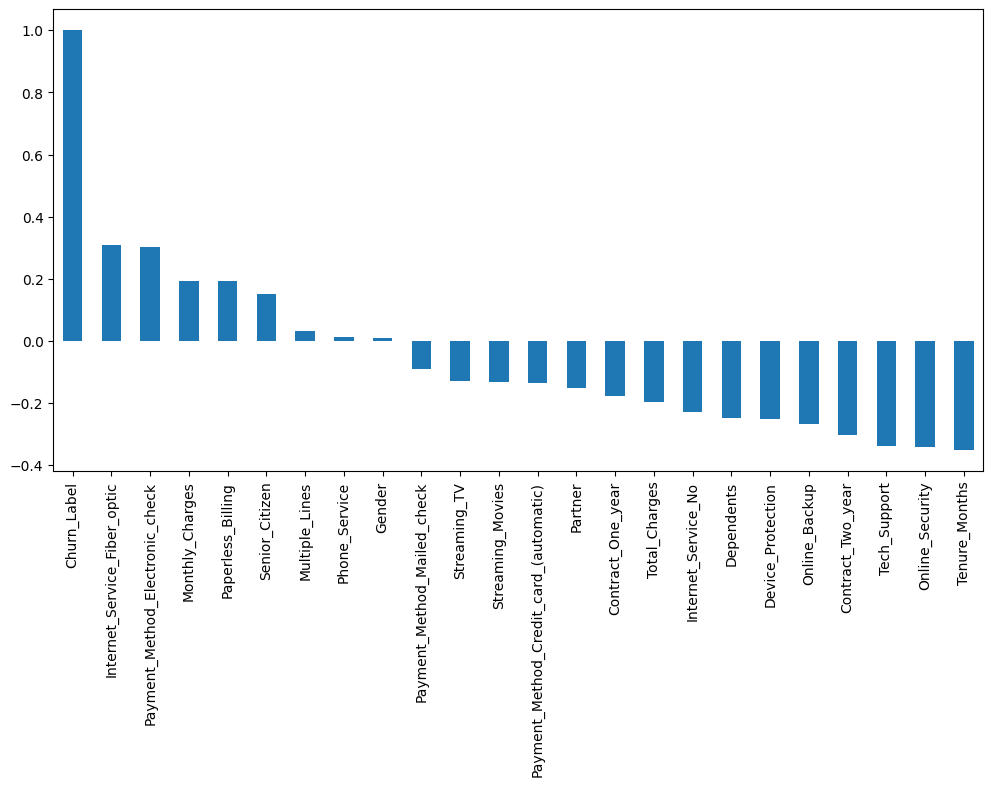

In [5]:
plt.figure(figsize=(12,6))
data.corr()['Churn_Label'].sort_values(ascending = False).plot(kind='bar')

In [6]:
X = data.drop(columns = ['Churn_Label'])
y = data['Churn_Label']

In [7]:
X.head()

,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Online_Security,Online_Backup,Device_Protection,...,Paperless_Billing,Monthly_Charges,Total_Charges,Internet_Service_Fiber_optic,Internet_Service_No,Contract_One_year,Contract_Two_year,Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,0,0,0,0,2,1,0,1,1,0,...,1,53.85,108.15,0,0,0,0,0,0,1
1,1,0,0,1,2,1,0,0,0,0,...,1,70.70,151.65,1,0,0,0,0,1,0
2,1,0,0,1,8,1,1,0,0,1,...,1,99.65,820.50,1,0,0,0,0,1,0
3,1,0,1,1,28,1,1,0,0,1,...,1,104.80,3046.05,1,0,0,0,0,1,0
4,0,0,0,1,49,1,1,0,1,1,...,1,103.70,5036.30,1,0,0,0,0,0,0


In [8]:
from sklearn.feature_selection import SelectKBest

selection = SelectKBest(k=12)
X_select = selection.fit_transform(X,y)
print(X_select)

[[ 0.  2.  1. ...  0.  0.  0.]
 [ 1.  2.  0. ...  0.  0.  1.]
 [ 1.  8.  0. ...  0.  0.  1.]
 ...
 [ 1. 72.  0. ...  0.  0.  0.]
 [ 1. 11.  1. ...  0.  0.  1.]
 [ 0. 66.  1. ...  0.  1.  0.]]


In [9]:
X = X[X.columns[selection.get_support()]]

In [10]:
print(len(X.columns))
list(X.columns)

12


['Dependents',
 'Tenure_Months',
 'Online_Security',
 'Online_Backup',
 'Device_Protection',
 'Tech_Support',
 'Monthly_Charges',
 'Total_Charges',
 'Internet_Service_Fiber_optic',
 'Internet_Service_No',
 'Contract_Two_year',
 'Payment_Method_Electronic_check']

# Modeling - Attempt 1

In [11]:
Models = []
print('Original Ratio: ', sum(y)/len(y))     
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)     
print('Split Ratio Train: ', sum(y_train)/len(y_train))
print('Split Ratio test: ', sum(y_test)/len(y_test))

Original Ratio:  0.2653698707936959
Split Ratio Train:  0.2654297614539947
Split Ratio test:  0.26519023282226006


In [12]:
# function to print the evalaution metrics
def eval_metrics(model, X_test, y_test):
    y_pred_model = model.predict(X_test)    
    y_probabilities = model.predict_proba(X_test)[:,1] 
    print('Precision: ', precision_score(y_test, y_pred_model))
    print('Recall: ', recall_score(y_test, y_pred_model))
    print('F1 Score: ', f1_score(y_test, y_pred_model))
    print('ROC AUC Score: ', roc_auc_score(y_test, y_probabilities))
    plt.figure(figsize=(12,6))
    
    plt.subplot(121)
    conf_mat = confusion_matrix(y_test, y_pred_model)
    sns.heatmap(conf_mat, fmt = "d",annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    
    model_roc_auc = roc_auc_score(y_test, y_probabilities) 
    fpr,tpr,thresholds = roc_curve(y_test, y_probabilities)
    plt.subplot(122)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

## 1. Logistics Regression

In [13]:
churn_lr = LogisticRegression(random_state=42, max_iter=1000)
churn_lr.fit(X_train, y_train)
Models.append(churn_lr)

Precision:  0.6522842639593909
Recall:  0.550321199143469
F1 Score:  0.596980255516841
ROC AUC Score:  0.8495253997200056


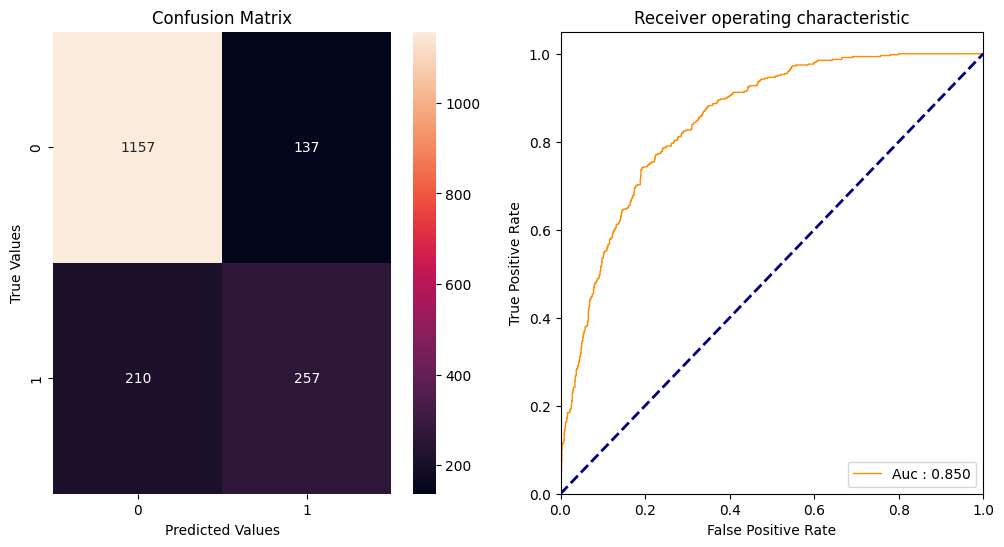

In [14]:
eval_metrics(churn_lr, X_test, y_test)

## 2. Decision Tree

In [15]:
churn_DT = DecisionTreeClassifier()

churn_DT.fit(X_train, y_train)

Models.append(churn_DT)

Precision:  0.4707112970711297
Recall:  0.4817987152034261
F1 Score:  0.47619047619047616
ROC AUC Score:  0.6491126894346829


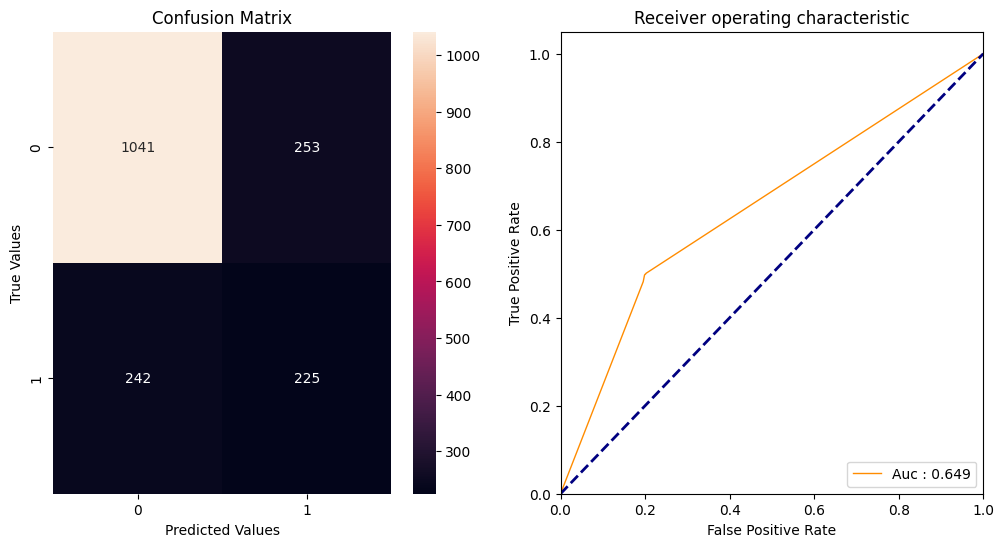

In [16]:
eval_metrics(churn_DT, X_test, y_test)

## 3. Random Forest

In [17]:
churn_rf = RandomForestClassifier(random_state=42)

churn_rf.fit(X_train, y_train)
Models.append(churn_rf)

Precision:  0.6090425531914894
Recall:  0.49036402569593146
F1 Score:  0.5432977461447213
ROC AUC Score:  0.8065970762769362


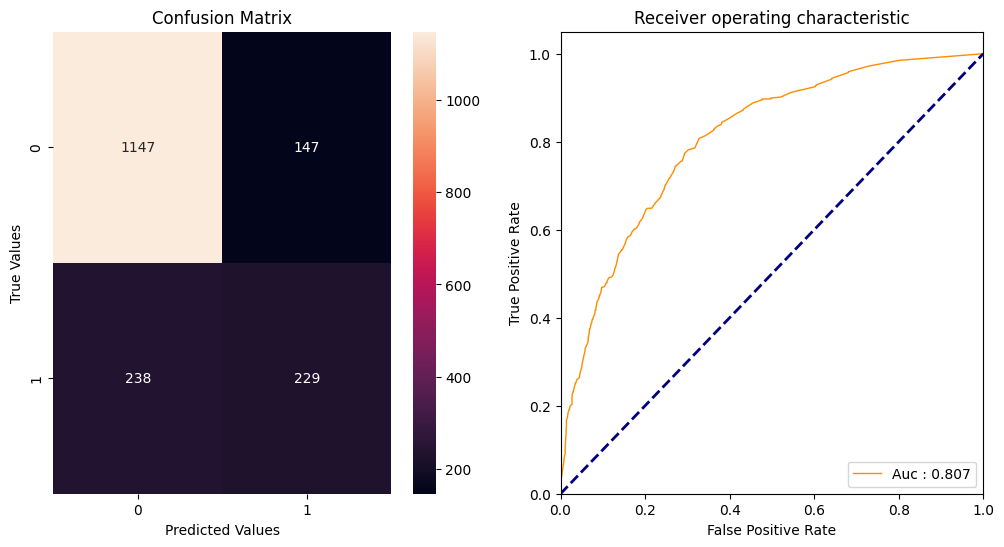

In [18]:
eval_metrics(churn_rf, X_test, y_test)

## 4. KNN

In [19]:
churn_knn = KNeighborsClassifier()

churn_knn.fit(X_train, y_train)
Models.append(churn_knn)

Precision:  0.5877192982456141
Recall:  0.430406852248394
F1 Score:  0.4969097651421508
ROC AUC Score:  0.7500852228536252


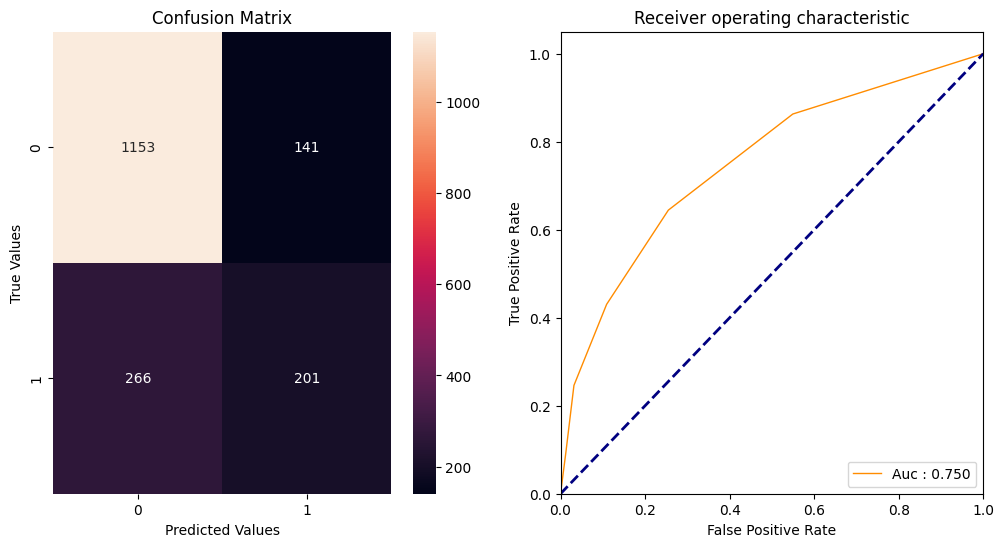

In [20]:
eval_metrics(churn_knn, X_test, y_test)

## 5. XGBoost

In [21]:
churn_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42)

churn_xgb.fit(X_train, y_train)
Models.append(churn_xgb)

Precision:  0.6036269430051814
Recall:  0.4989293361884368
F1 Score:  0.5463071512309495
ROC AUC Score:  0.8221308030144067


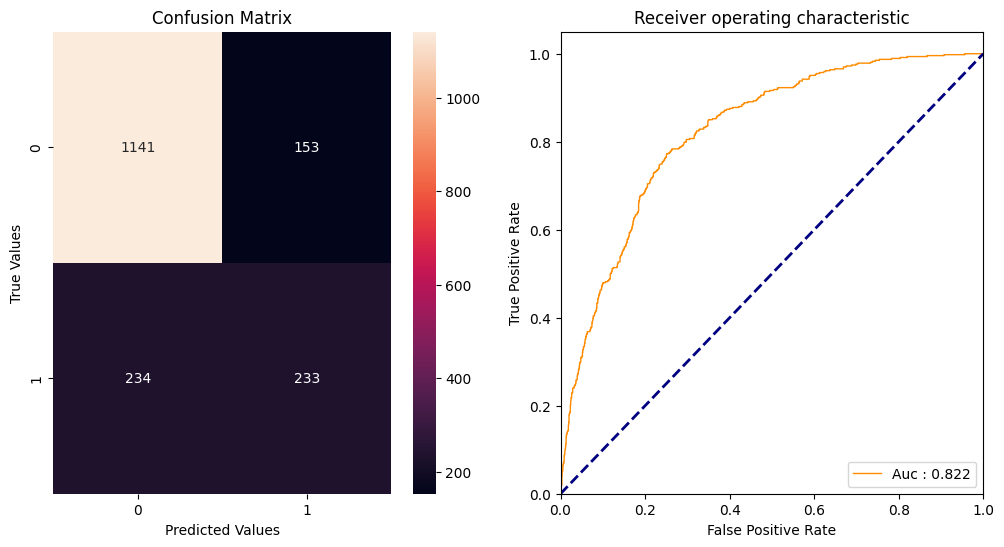

In [22]:
eval_metrics(churn_xgb, X_test, y_test)

## Model Comparision using K-Fold Cross Validation

In [23]:
result_col = ["Algorithm", "AUC Mean","Bal Acc Mean", 'Recall']
model_results = pd.DataFrame(columns = result_col)

i=0

for model in Models:
    kfold = KFold(n_splits=10)
    
    cv_acc_results = cross_val_score(model, X_train, y_train, 
                    cv = kfold, scoring="balanced_accuracy")
    cv_auc_results = cross_val_score(model, X_train, y_train,
                    cv = kfold, scoring="roc_auc")
    cv_recall_results = cross_val_score(model, X_train, y_train,
                    cv = kfold, scoring="recall")
    
    model_results.loc[i] = [model.__class__.__name__, 
                           round(cv_auc_results.mean()*100,2),
                           round(cv_acc_results.mean()*100,2),
                           round(cv_recall_results.mean()*100,2)]
    i+=1

model_results.sort_values(by = ['AUC Mean'], ascending=False)

,Algorithm,AUC Mean,Bal Acc Mean,Recall
0,LogisticRegression,84.98,72.26,54.46
4,XGBClassifier,83.67,70.50,53.46
2,RandomForestClassifier,82.15,69.59,51.00
3,KNeighborsClassifier,73.85,65.38,43.36
1,DecisionTreeClassifier,66.79,66.37,51.15


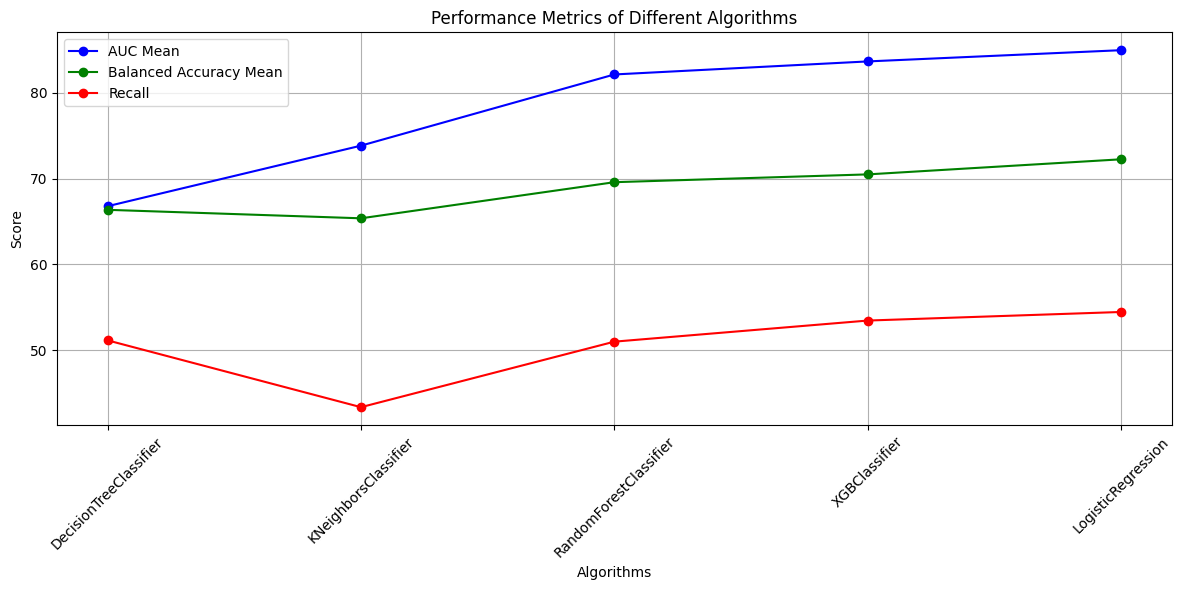

<Figure size 640x480 with 0 Axes>

In [24]:
model_results = model_results.sort_values(by = ['AUC Mean'])

plt.figure(figsize=(12, 6))

plt.plot(model_results['Algorithm'], model_results['AUC Mean'], marker='o', label='AUC Mean', color='b')
plt.plot(model_results['Algorithm'], model_results['Bal Acc Mean'], marker='o', label='Balanced Accuracy Mean', color='g')
plt.plot(model_results['Algorithm'], model_results['Recall'], marker='o', label='Recall', color='r')

plt.xticks(rotation=45)
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.title('Performance Metrics of Different Algorithms')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
plt.savefig("before.png")

# Modeling - Attempt 2

In [25]:
st=SMOTEENN()
X_st,y_st = st.fit_resample(X, y)
print("The number of classes before fit {}".format(Counter(y)))
print("The number of classes after fit {}".format(Counter(y_st)))

The number of classes before fit Counter({0: 5174, 1: 1869})
The number of classes after fit Counter({1: 3044, 0: 2683})


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_st, y_st, random_state=42, stratify=y_st)

In [27]:
# function to perform gridsearchcv

def gridsearchcv(model, params, scoring):
    grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=4, cv=5,verbose=1, scoring=scoring)
    grid.fit(X_train, y_train)
    return grid

### Fitting all models on new sampled data

In [28]:
Models_Sampled = []

Models_Sampled.append(LogisticRegression(random_state=42, max_iter=1000))
Models_Sampled.append(DecisionTreeClassifier())
Models_Sampled.append(RandomForestClassifier(random_state=42))
Models_Sampled.append(KNeighborsClassifier())
Models_Sampled.append(xgb.XGBClassifier(objective='binary:logistic', seed=42))


### Model Comparision using K-Fold Cross Validation

In [29]:
result_col = ["Algorithm", "AUC Mean","Bal Acc Mean", 'Recall']
model_results_sampled = pd.DataFrame(columns = result_col)

i=0

for model in Models_Sampled:
    kfold = KFold(n_splits=10)
    
    cv_acc_results = cross_val_score(model, X_train, y_train, 
                    cv = kfold, scoring="balanced_accuracy")
    cv_auc_results = cross_val_score(model, X_train, y_train,
                    cv = kfold, scoring="roc_auc")
    cv_recall_results = cross_val_score(model, X_train, y_train,
                    cv = kfold, scoring="recall")
    
    model_results_sampled.loc[i] = [model.__class__.__name__, 
                           round(cv_auc_results.mean()*100,2),
                           round(cv_acc_results.mean()*100,2),
                           round(cv_recall_results.mean()*100,2)]
    i+=1

model_results_sampled.sort_values(by = ['AUC Mean'], ascending=False)

,Algorithm,AUC Mean,Bal Acc Mean,Recall
2,RandomForestClassifier,98.78,94.44,95.40
4,XGBClassifier,98.77,94.72,95.92
3,KNeighborsClassifier,98.50,94.69,96.14
0,LogisticRegression,98.16,92.86,93.74
1,DecisionTreeClassifier,92.95,92.99,93.85


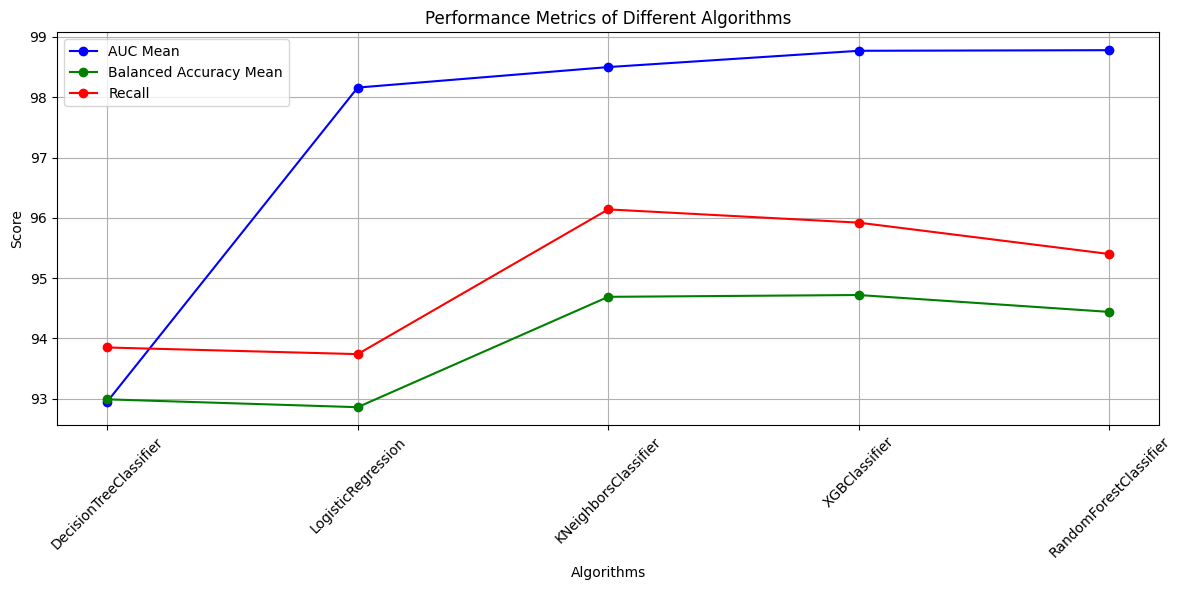

In [30]:
model_results_sampled = model_results_sampled.sort_values(by = ['AUC Mean'])

plt.figure(figsize=(12, 6))

plt.plot(model_results_sampled['Algorithm'], model_results_sampled['AUC Mean'], marker='o', label='AUC Mean', color='b')
plt.plot(model_results_sampled['Algorithm'], model_results_sampled['Bal Acc Mean'], marker='o', label='Balanced Accuracy Mean', color='g')
plt.plot(model_results_sampled['Algorithm'], model_results_sampled['Recall'], marker='o', label='Recall', color='r')

plt.xticks(rotation=45)
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.title('Performance Metrics of Different Algorithms')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### XGBoost

In [31]:
xgb_grid_params = {'max_depth': [3,4,5, 6],
                 'learning_rate': [0.01, 0.05, 0.1, 0.2],
                 'gamma':[0,0.25,0.5, 0.75],
                 'reg_lambda': [0,5,10,15],
                 'scale_pos_weight': [3,5,7]
                }

xgb_model = xgb.XGBClassifier(objective='binary:logistic', seed=42)
xgb_grid = gridsearchcv(xgb_model, xgb_grid_params, 'roc_auc')

print('Best Params: ', xgb_grid.best_params_)
print('Best Score: ', xgb_grid.best_score_)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best Params:  {'gamma': 0.25, 'learning_rate': 0.2, 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 7}
Best Score:  0.9879911610394458


In [32]:
best_params = xgb_grid.best_params_
churn_xgb_optimal = xgb.XGBClassifier(objective='binary:logistic', learning_rate=best_params['learning_rate'],
                                      max_depth=best_params['max_depth'], reg_lambda=best_params['reg_lambda'],
                                      gamma=best_params['gamma'], scale_pos_weight=best_params['scale_pos_weight'],
                                      seed= 42)

churn_xgb_optimal.fit(X_train, y_train,
                     early_stopping_rounds=10,
                     eval_metric='aucpr',
                     eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.90721
[1]	validation_0-aucpr:0.98168
[2]	validation_0-aucpr:0.98291
[3]	validation_0-aucpr:0.98503
[4]	validation_0-aucpr:0.98511
[5]	validation_0-aucpr:0.98570
[6]	validation_0-aucpr:0.98559
[7]	validation_0-aucpr:0.98624
[8]	validation_0-aucpr:0.98800
[9]	validation_0-aucpr:0.98909
[10]	validation_0-aucpr:0.98951
[11]	validation_0-aucpr:0.98979
[12]	validation_0-aucpr:0.98991


[13]	validation_0-aucpr:0.98972
[14]	validation_0-aucpr:0.98977
[15]	validation_0-aucpr:0.98981
[16]	validation_0-aucpr:0.98985
[17]	validation_0-aucpr:0.98997
[18]	validation_0-aucpr:0.99004
[19]	validation_0-aucpr:0.99033
[20]	validation_0-aucpr:0.99046
[21]	validation_0-aucpr:0.99035
[22]	validation_0-aucpr:0.99060
[23]	validation_0-aucpr:0.99074
[24]	validation_0-aucpr:0.99090
[25]	validation_0-aucpr:0.99096
[26]	validation_0-aucpr:0.99093
[27]	validation_0-aucpr:0.99117
[28]	validation_0-aucpr:0.99115
[29]	validation_0-aucpr:0.99120
[30]	validation_0-aucpr:0.99124
[31]	validation_0-aucpr:0.99123
[32]	validation_0-aucpr:0.99139
[33]	validation_0-aucpr:0.99126
[34]	validation_0-aucpr:0.99130
[35]	validation_0-aucpr:0.99167
[36]	validation_0-aucpr:0.99194
[37]	validation_0-aucpr:0.99189
[38]	validation_0-aucpr:0.99197
[39]	validation_0-aucpr:0.99215
[40]	validation_0-aucpr:0.99235
[41]	validation_0-aucpr:0.99238
[42]	validation_0-aucpr:0.99246
[43]	validation_0-aucpr:0.99258
[44]	val

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Precision:  0.93875


Recall:  0.9868593955321945
F1 Score:  0.9622037155669442
ROC AUC Score:  0.9934669066312073


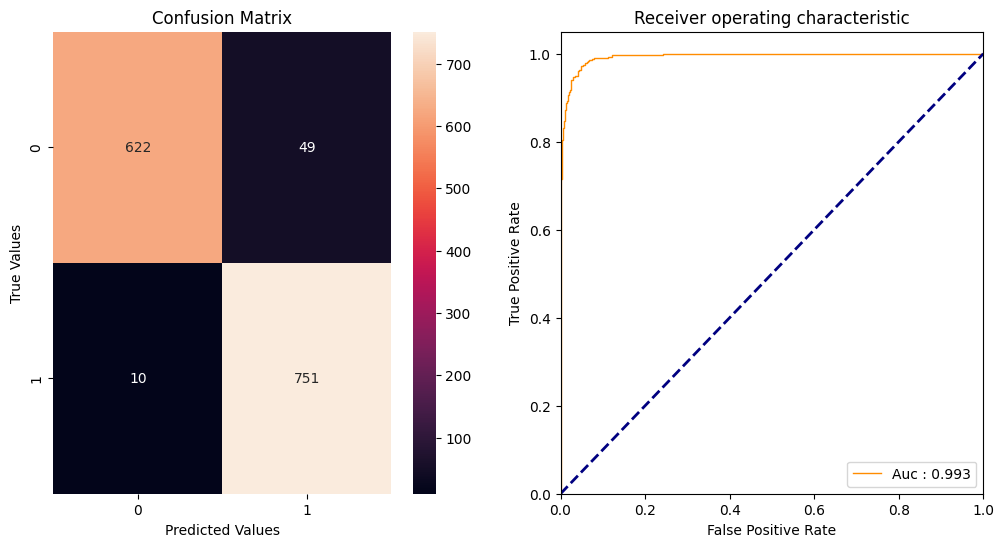

In [33]:
eval_metrics(churn_xgb_optimal, X_test, y_test)

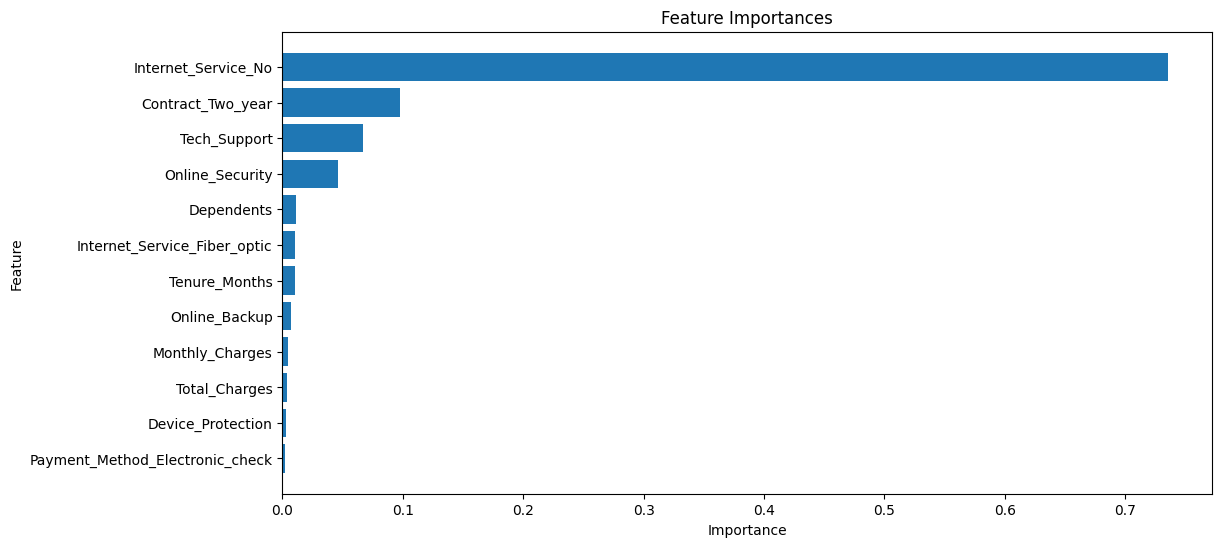

In [34]:
importances = churn_xgb_optimal.feature_importances_

feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [35]:
import pickle
pickle.dump(churn_xgb_optimal, open('churn_xgb_optimal.pkl','wb'))